In [8]:
import os
import pandas as pd
import numpy as np

# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import sklearn 

import datetime as dt
from datetime import timedelta 
from datetime import date

# plotting candlestick graphs
import mplfinance as mpf

# stock data api
from iexfinance.stocks import Stock
from iexfinance.stocks import get_historical_data
import quandl as ql
import yfinance as yf
# import helper file for functions
import helper

In [6]:
style.use('ggplot')
# quandl api key activation
ql.ApiConfig.api_key = open("ql_api_token.txt").read()


,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
2017-12-21,86.05,86.1000,85.400,85.50,17990745.0,0.0,1.0,82.753184,82.801268,82.128087,82.224256,17990745.0
2017-12-22,85.40,85.6300,84.920,85.51,14145841.0,0.0,1.0,82.128087,82.349275,81.666477,82.233873,14145841.0
2017-12-26,85.31,85.5346,85.030,85.40,9891237.0,0.0,1.0,82.041535,82.257530,81.772263,82.128087,9891237.0
2017-12-27,85.65,85.9800,85.215,85.71,14678025.0,0.0,1.0,82.368509,82.685866,81.950175,82.426210,14678025.0
2017-12-28,85.90,85.9300,85.550,85.72,10594344.0,0.0,1.0,82.608931,82.637781,82.272340,82.435827,10594344.0


In [ ]:
# Start: 1st trading day in 2014 
start = dt.datetime(2014,1,2)
# latest close date 
end = date.today()
# Using quandl api to retrieve historical data on ticker MSFT (Microsoft)
eod_msft_data = ql.get('EOD/MSFT', start_date=start, end_date=end)
# eod_msft_data.head()
eod_msft_data.tail()
# Free EOD data is limited to end of 2017

In [25]:
# trim down dataframe to necessary columns
adj_close_msft_2017 = eod_msft_data[['Volume','Adj_Close']] 
adj_close_msft_2017.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2014-01-02 to 2017-12-28
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Volume     1006 non-null   float64
 1   Adj_Close  1006 non-null   float64
dtypes: float64(2)
memory usage: 23.6 KB


In [32]:
# Get remaining data from Yahoo Finance
msft_yf= yf.download('MSFT',start='2018-01-02',end='2019-12-28')
# msft_yf.head()


[*********************100%***********************]  1 of 1 completed


In [33]:
msft_yf.columns = ['Open','High','Low','Close','Adj_Close','Volume']
msft_yf.head()

,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2018-01-02,86.129997,86.309998,85.500000,85.949997,82.383636,22483800
2018-01-03,86.059998,86.510002,85.970001,86.349998,82.767044,26061400
2018-01-04,86.589996,87.660004,86.570000,87.110001,83.495522,21912000
2018-01-05,87.660004,88.410004,87.430000,88.190002,84.530701,23407100
2018-01-08,88.199997,88.580002,87.599998,88.279999,84.616966,22113000


In [24]:
adj_close_msft_2019 = msft_yf[['Adj_Close','Volume']]
adj_close_msft_2019.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 501 entries, 2018-01-02 to 2019-12-27
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj_Close  501 non-null    float64
 1   Volume     501 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 11.7 KB


In [23]:
# concatenate dataframes
adj_close_msft_merged = adj_close_msft_2017.append(adj_close_msft_2019)
adj_close_msft_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1507 entries, 2014-01-02 to 2019-12-27
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Volume     1507 non-null   float64
 1   Adj_Close  1507 non-null   float64
dtypes: float64(2)
memory usage: 35.3 KB


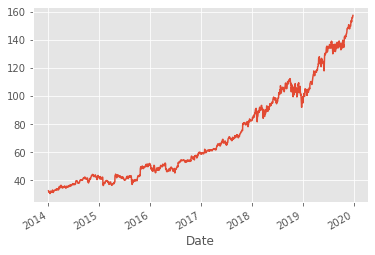

In [27]:
adj_close_msft_merged['Adj_Close'].plot()

We can plot multiple plots into one plot by using subplot, and get the adjusted closing value, the 100 day moving average and trading volume on the same plot. 

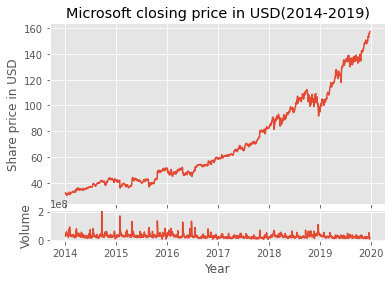

In [30]:
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1,sharex=ax1)
ax1.plot(adj_close_msft_merged.index, adj_close_msft_merged['Adj_Close'])
ax2.plot(adj_close_msft_merged.index, adj_close_msft_merged['Volume'])
ax1.set_title('Microsoft closing price in USD(2014-2019)')
ax1.set(ylabel='Share price in USD')
ax2.set(ylabel='Volume')
ax2.set(xlabel='Year')

plt.show()

As shown above, the graph shows an exponential rise in share value with the 100 day moving average 

In [35]:
# Daily prices including highs and lows with volume for hockeystick graph
full_msft_df = eod_msft_data[['Open','High','Low','Close','Adj_Close','Volume']].append(msft_yf)
# Creating a candle-stick graph
# If a stock underwent a split, you'd have to create a new dataset based on the Adjusted Close values.
df_ohlc = full_msft_df['Adj_Close'].resample('10D').ohlc()
df_vol = full_msft_df['Volume'].resample('10D').sum()
print (df_ohlc.tail())

                  open        high         low       close
Date                                                      
2019-11-12  145.034821  148.308868  145.034821  147.913040
2019-11-22  148.021912  150.723297  148.021912  149.793152
2019-12-02  147.982330  150.159271  147.744843  150.109772
2019-12-12  151.633667  155.759949  151.633667  155.759949
2019-12-22  155.759949  157.293686  155.730255  157.293686


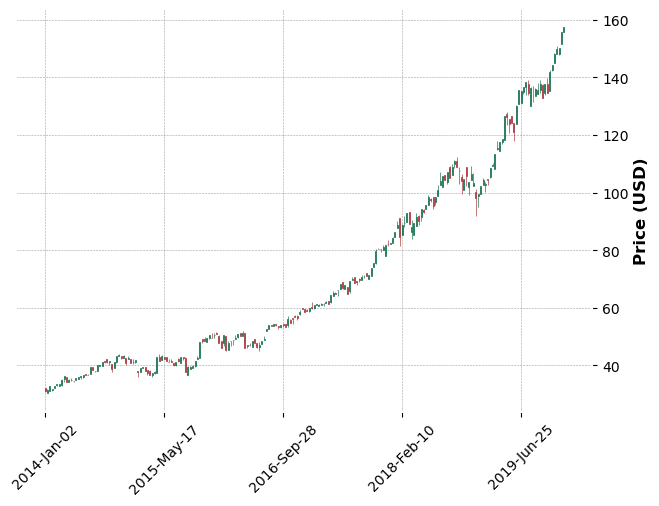

In [36]:
mpf.plot(
    df_ohlc, 
    type='candlestick',
    style='charles',
    ylabel='Price (USD)')


This is just a static candlestick graph that shows all the trading action since 2015. The red candles depict selling of the stock, the green indicates buying. 